**ML (CS60050) Project 2** \
**Group: 13** \
**Project Code: WSNN** \
**Project Title: Wheat Seeds Classification using ANN** \
**Group members:**

*   Anuj Parashar (22CS60R82)
*   Raj Shekhar Vaghela (22CS60R32)
*   Shaswata Dutta (19EC39034)

**Note: Only after uploading the *seeds_dataset.txt* text file, the entire notebook should be run**



# **Part 1: Building own Neural Network**

## Code for **ANN Specification 1** 

#### **Importing necessary libraries**

In [280]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd 
import math

#### **Data preprocessing**

In [281]:
data=[]
temp=[]
with open('seeds_dataset.txt') as f:
    lines=f.read()
    
lines=lines.split('\n')
for i in range(len(lines)):
    lines[i]=lines[i].split('\t')
for i in range(len(lines)):
    while len(lines[i])>8:
        lines[i].remove('')
for i in range(len(lines)):
    temp=[]
    for j in range(8):
        temp.append(float(lines[i][j]))
    data.append(temp)
    
data=np.array(data)

Creation of **Train-Test split**

In [282]:
np.random.shuffle(data)
X = data[:, [0,1,2,3,4,5,6]]
Y = data[:, [-1]]
n_train = math.floor(0.8 * X.shape[0])
n_test = math.ceil((0.2) * X.shape[0])
X_train = X[:n_train]
y_train = Y[:n_train]
X_test = X[n_train:]
y_test = Y[n_train:]
print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

Total Number of rows in train: 168
Total Number of rows in test: 42


The above training and test data will be used both for **ANN1** and **ANN2**

#### Building the **structure of the neural network**

In [283]:
class Layer:
    def __init__(self,no_neuron_1, no_neuron_2):
        self.weights = np.random.uniform(low=-1, high=1, size=(no_neuron_1,  no_neuron_2)) 
        self.biases = np.zeros((1, no_neuron_2)) # function to initialize random weights to layers 
    def forward_hidden(self,data):
        self.output_hidden = 1/(1+np.exp(-(np.dot(data, self.weights) + self.biases)))#hidden layer function
    def forward_output(self,data):
        self.final_output = np.dot(data,self.weights)+self.biases # outer layer output before softmax
# Layer class to assign weights to layers and perform forward pass
        
def softmax(y):
    y=np.exp(y)
    return y/y.sum()
    
        
layer_I_H = Layer(7,32)
layer_H_O = Layer(32,3)
# creating layers 

#### Forward function for **Feed-forwarding through the Neural Network**

In [284]:
last_output_softmax=[]
actual=[] 
def forward(batch_data,y_train): # function to do forward pass
    layer_I_H.forward_hidden(batch_data)   
    layer_H_O.forward_output(layer_I_H.output_hidden) 
    
    last_output_softmax.clear()
    for i in range(len(layer_H_O.final_output)):
        last_output_softmax.append(list(softmax(layer_H_O.final_output[i])))
    global actual
    actual.clear()
    for i in range(len(y_train)): # one hot encoding of target value
        if y_train[i]==1 :
            actual.append([1,0,0])
        elif y_train[i]==2 :
            actual.append([0,1,0])
        else:
            actual.append([0,0,1])
   # actual=np.array(actual)   
    loss(actual)

#### Computing Loss (using **Categorical Cross Entropy Loss**)

In [285]:
final_loss=[]
def loss(actual): # function to calculate loss
    final_loss.clear()
    for i in range(len(actual)):
        temp=-(math.log(last_output_softmax[i][0])*actual[i][0]+
              math.log(last_output_softmax[i][1])*actual[i][1]+
              math.log(last_output_softmax[i][2])*actual[i][2])
        final_loss.append(temp) 
    #print("loss is :--")    
    #print(final_loss)     

#### Backward function for **Backpropagation in Neural Network**

In [286]:
lr = 0.01    # learning rate
def sigmoid_deriv(s):     # element-wise computation of the derivative of sigmoid function 
    return s * (1 - s)
    
def backward_final(X, y, y_pred,no_of_hidden_layer,y_train, t):
    m = len(y)
    if (no_of_hidden_layer == 1 and t==1) :
        # Updating weights and biases between hidden layer and output layer
        y_pred=np.array(y_pred)
        y=np.array(y)
        delta_O = y_pred - y       # delta gradient of output layer
        a_H = layer_I_H.output_hidden             # (32, 32) -> a1
        d_weight_H_O = np.dot(a_H.T, delta_O)/m   # derivate of weights between hidden layer and output layer
        d_bias_O = np.sum(delta_O, axis = 0, keepdims=True)/m    # derivative of biases of output layer
        
        # Updating weights and biases between input layer and hidden layer
        delta_H = np.dot(delta_O, layer_H_O.weights.T) * sigmoid_deriv(a_H)      # delta gradient of Hidden layer
        d_weight_I_H = np.dot(X.T, delta_H)/m  # derivate of weights between Input layer and Hidden layer
        d_bias_H = np.sum(delta_H, axis = 0, keepdims=True)/m   # derivative of biases of Hidden layer
        
        # Updating weights and biases now
        layer_H_O.weights -= lr * d_weight_H_O     # weights between hidden and output layer
        layer_H_O.biases -= lr * d_bias_O          # biases between hidden and output layer
        layer_I_H.weights -= lr * d_weight_I_H     # weights between input and hidden layer
        layer_I_H.biases -= lr * d_bias_H          # biases between input and hidden layer
        
    acc = accuracy(last_output_softmax,y_train)
    return acc

#backward_final(X_train[:32], actual, last_output_softmax,1)        


#### Computing the **accuracy of our model**

In [287]:
def accuracy(last_output_softmax,y_train): # function to calculate accuracy
    correct=0
    incorrect=0
    for i in range(len(last_output_softmax)):
    
        if last_output_softmax[i][0] > last_output_softmax[i][1] and last_output_softmax[i][0] > last_output_softmax[i][2]:
            pred_class=1
        elif last_output_softmax[i][1] > last_output_softmax[i][0] and last_output_softmax[i][1] > last_output_softmax[i][2]:
            pred_class=2
        else:
            pred_class=3
        if pred_class== y_train[i]:
            correct+=1
        else:
            incorrect+=1
    return ((correct/len(last_output_softmax))*100)
    # print("accuracy in percentage =  ",(correct/len(last_output_softmax))*100,"%" )        

#### **Training the model**

We also print the training and test accuracy for each epoch.

In [288]:
acc_arr = []
acc_test_arr = []
for i in range(200): # running 200 epochs
    avg_acc = 0
    avg_test_acc = 0
    start=0
    end=32
    cnt = 0
    print("information for epoch=",i+1)
    while end<=len(X_train):
        cnt = cnt+1
        forward(X_train[start:end],y_train[start:end])
        acc1 = backward_final(X_train[start:end],actual,last_output_softmax,1,y_train[start:end], 1)
        forward(X_test,y_test) # train the data
        acctest = backward_final(X_test,actual,last_output_softmax,1,y_test,0)
        print("     accuracy of batch ", cnt, " = ", acc1)
        avg_acc += acc1
        avg_test_acc += acctest
        # avg_acc = avg_acc + acc1*32
        # acc1 = acc1*32
        start+=32
        if end == len(X_train):
            break
        end+=32
        if end>len(X_train):
            end=len(X_train)
        
        # print(cnt)
    # avg_acc /= len(X_train)
    avg_acc /= 6
    avg_test_acc /= 6
    acc_arr.append(avg_acc)
    acc_test_arr.append(avg_test_acc)
    # print("Average accuracy for epoch ", i+1, " is ", avg_acc)
    if((i+1)%10 == 0):
        print("For epoch ", i+1, ", average training accuracy: ", avg_acc, "\n")
        print("For epoch ", i+1, ", average test accuracy: ", avg_test_acc, "\n")

information for epoch= 1
     accuracy of batch  1  =  34.375
     accuracy of batch  2  =  34.375
     accuracy of batch  3  =  40.625
     accuracy of batch  4  =  31.25
     accuracy of batch  5  =  25.0
     accuracy of batch  6  =  37.5
information for epoch= 2
     accuracy of batch  1  =  34.375
     accuracy of batch  2  =  34.375
     accuracy of batch  3  =  40.625
     accuracy of batch  4  =  31.25
     accuracy of batch  5  =  25.0
     accuracy of batch  6  =  37.5
information for epoch= 3
     accuracy of batch  1  =  34.375
     accuracy of batch  2  =  34.375
     accuracy of batch  3  =  40.625
     accuracy of batch  4  =  31.25
     accuracy of batch  5  =  25.0
     accuracy of batch  6  =  37.5
information for epoch= 4
     accuracy of batch  1  =  34.375
     accuracy of batch  2  =  34.375
     accuracy of batch  3  =  40.625
     accuracy of batch  4  =  31.25
     accuracy of batch  5  =  25.0
     accuracy of batch  6  =  37.5
information for epoch= 5
     ac

#### **Plotting the accuracies**

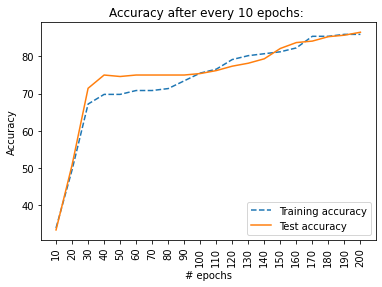

In [289]:
acc10 = [acc_arr[i] for i in range(0, 200, 10)]
acc_test10 = [acc_test_arr[i] for i in range(0, 200, 10)]
xlab = [i for i in range(20)]
lab = [i*10 for i in range(1, 21)]
plt.plot(xlab, acc10, '--', label = "Training accuracy")
plt.plot(xlab, acc_test10, '-', label = "Test accuracy")
plt.title("Accuracy after every 10 epochs: ")
plt.legend(loc="lower right")
plt.xlabel("# epochs")
plt.ylabel("Accuracy")
plt.xticks(xlab, lab, rotation = "vertical")

plt.show()

#### Displaying **Final training and test accuracy**

In [290]:
print("Final training accuracy = ", acc_arr[199], "%")
print("Final test accuracy = ", acc_test_arr[199], "%")

Final training accuracy =  87.5 %
Final test accuracy =  87.30158730158729 %


## Code for **ANN Specification 2**

#### Building the **structure of the neural network**

In [291]:
# Layer class for defining the layers of our neural network
class Layer:# Layer_Dense-> Layer
    def __init__(self,no_neuron_1, no_neuron_2):
        self.weights = np.random.uniform(low = -1, high = 1, size = (no_neuron_1, no_neuron_2))
        self.biases = np.random.uniform(low = -1, high = 1, size = (1, no_neuron_2))
        
    def forward_hidden(self,data):
        self.z = np.dot(data, self.weights) + self.biases   # hidden layer function - Relu
        self.output_hidden = relu(self.z)
        
    def forward_output(self,data):
        self.final_output= np.dot(data,self.weights)+self.biases       # outer layer output before applying softmax

        
def softmax(y):
    y = np.exp(y)
    return y/(y.sum())

def relu(x):
    return np.maximum(x, 0)
        
layer_I_H = Layer(7,64)    # 1st hidden layer
layer_H_H = Layer(64,32)   # 2nd hidden layer
layer_H_O = Layer(32,3)    # output layer

#### Forward function for **Feed-forwarding through the Neural Network**

In [292]:
last_output_softmax=[]
actual=[] 
def forward(batch_data,y_train):
    m = len(y_train)
    layer_I_H.forward_hidden(batch_data)        # passing the input data to the 1st hidden layer
    layer_H_H.forward_hidden(layer_I_H.output_hidden)    # passing the 1st hidden layer outputs to the 2nd hidden layer
    layer_H_O.forward_output(layer_H_H.output_hidden)    # passing the 2nd hidden layer outputs to the output layer
    
    last_output_softmax.clear()
    for i in range(len(layer_H_O.final_output)):
        last_output_softmax.append(list(softmax(layer_H_O.final_output[i])))    # appending the last outputs to an array after applying softmax activation function on them
    global actual
    actual.clear()
    for i in range(len(y_train)):     # performing one-hot encoding on actual outputs
        if y_train[i]==1 :
            actual.append([1,0,0])
        elif y_train[i]==2 :
            actual.append([0,1,0])
        else:
            actual.append([0,0,1])
   # actual=np.array(actual)   
#     loss(actual)
    # print(last_output_softmax)
# forward(X_train[:32], y_train[:32])

#### Computing Loss (using **Categorical Cross Entropy Loss**)

In [293]:
# final_loss=[]
def loss(label):           # applying categorical crossentropy loss function here
    final_loss = []
    for i in range(len(label)):
        temp=-(math.log(last_output_softmax[i][0])*label[i][0]+
              math.log(last_output_softmax[i][1])*label[i][1]+
              math.log(last_output_softmax[i][2])*label[i][2])
        final_loss.append(temp)
        # print("Loss is :..... ", temp)
    # print("loss is :--")    
    return(final_loss)     

#### Backward function for **Backpropagation in Neural Network**

In [294]:
learning_rate = 0.01
no_of_hidden_layer = 2
    
def backward_final(X, y, y_pred, no_of_hidden_layer, y_train, t):
    m = len(y)
    if (no_of_hidden_layer == 1 and t == 1):
        # Updating weights and biases between hidden layer and output layer
        # print("Loss = ", loss(y))
        delta_O = y_pred - y       # delta gradient of output layer
        a_H = layer_I_H.output_hidden             # (32, 32) -> a1   outputs of the hidden layer
        d_weight_H_O = np.dot(a_H.T, delta_O)/m    # derivate of weights between hidden layer and output layer
        d_bias_O = np.sum(delta_O, axis = 0, keepdims=True)/m   # derivative of biases of output layer
        
        # Updating weights and biases between input layer and hidden layer
        delta_H = (np.dot(delta_O, layer_H_O.weights.T)*(a_H>0))/m     # delta gradient of Hidden layer
        d_weight_I_H = np.dot(X.T, delta_H)  # derivate of weights between Input layer and Hidden layer
        d_bias_H = np.sum(delta_H, axis = 0, keepdims=True)   # derivative of biases of Hidden layer
        
        # Updating weights and biases now
        layer_H_O.weights -= learning_rate * d_weight_H_O     # weights between hidden and output layer
        layer_H_O.biases -= learning_rate * d_bias_O          # biases between hidden and output layer
        layer_I_H.weights -= learning_rate * d_weight_I_H     # weights between input and hidden layer
        layer_I_H.biases -= learning_rate * d_bias_H          # biases between input and hidden layer

    elif (no_of_hidden_layer == 2 and t == 1):
        # print("Loss = ", loss(y))
        # Updating weights and biases between hidden layer and output layer
        y_pred = np.array(y_pred)
        y = np.array(y)
        
        delta_H_O = y_pred - y       # delta gradient of output layer
        a_H_O = layer_H_H.output_hidden             # (32, 32) -> a1    outputs of 2nd hidden layer
        d_weight_H_O = np.dot(a_H_O.T, delta_H_O)/m   # derivate of weights between hidden layer and output layer
        d_bias_O = np.sum(delta_H_O, axis = 0, keepdims=True)/m   # derivative of biases of output layer

        # Updating weights and biases between 1st hidden layer and 2nd hidden layer
        delta_H_H = (np.dot(delta_H_O, layer_H_O.weights.T)*(a_H_O>0))/m     # delta gradient of 2nd Hidden layer
        a_H_H = layer_I_H.output_hidden             # (32, 32) -> a1    outputs of 1st hidden layer
        d_weight_H_H = np.dot(a_H_H.T, delta_H_H)  # derivate of weights between 1st hidden layer and 2nd hidden layer
        d_bias_H_H = np.sum(delta_H_H, axis = 0, keepdims=True)  # derivative of biases of 2nd hidden layer
        
        # Updating weights and biases between input layer and 1st hidden layer
        delta_I_H = (np.dot(delta_H_H, layer_H_H.weights.T)*(a_H_H>0))/m   # delta gradient of 1st Hidden layer
        d_weight_I_H = np.dot(X.T, delta_I_H)   # derivate of weights between Input layer and Hidden layer
        d_bias_H = np.sum(delta_I_H, axis = 0, keepdims=True)    # derivative of biases of Hidden layer
        
        # Updating weights and biases now
        layer_H_O.weights -= learning_rate * d_weight_H_O     # weights between 2nd hidden and output layer
        layer_H_O.biases -= learning_rate * d_bias_O          # biases between 2nd hidden and output layer
        layer_H_H.weights -= learning_rate * d_weight_H_H     # weights between 1st hidden and 2nd hidden layer
        layer_H_H.biases -= learning_rate * d_bias_H_H        # biases between 1st hidden and 2nd hidden layer
        layer_I_H.weights -= learning_rate * d_weight_I_H     # weights between input and 1st hidden layer
        layer_I_H.biases -= learning_rate * d_bias_H          # biases between input and 1st hidden layer
        
    # accuracy(last_output_softmax,y_train)
    acc = accuracy(last_output_softmax,y_train)
    return acc

#### Computing the **accuracy of our model**

In [295]:
def accuracy(last_output_softmax, y_train):
    correct=0
    incorrect=0
    for i in range(len(last_output_softmax)):
    
        if last_output_softmax[i][0] > last_output_softmax[i][1] and last_output_softmax[i][0] > last_output_softmax[i][2]:
            pred_class=1
        elif last_output_softmax[i][1] > last_output_softmax[i][0] and last_output_softmax[i][1] > last_output_softmax[i][2]:
            pred_class=2
        else:
            pred_class=3
        if pred_class== y_train[i]:
            correct+=1
        else:
            incorrect+=1
    return ((correct/len(last_output_softmax))*100)
    # print("accuracy in percentage =  ",(correct/len(last_output_softmax))*100,"%" )        

#### **Training the model**

We also print the training and test accuracy for each epoch.

In [296]:
acc_arr = []
acc_test_arr = []
for i in range(200): # running 200 epochs
    avg_acc = 0
    avg_test_acc = 0
    start=0
    end=32
    cnt = 0
    print("information for epoch=",i+1)
    while end<=len(X_train):
        cnt = cnt+1
        forward(X_train[start:end],y_train[start:end])
        acc1 = backward_final(X_train[start:end],actual,last_output_softmax,2,y_train[start:end], 1)
        forward(X_test,y_test) # train the data
        acctest = backward_final(X_test,actual,last_output_softmax,2,y_test,0)
        print("     accuracy of batch ", cnt, " = ", acc1)
        avg_acc += acc1
        avg_test_acc += acctest
        # avg_acc = avg_acc + acc1*32
        # acc1 = acc1*32
        start+=32
        if end == len(X_train):
            break
        end+=32
        if end>len(X_train):
            end=len(X_train)
        
        # print(cnt)
    # avg_acc /= len(X_train)
    avg_acc /= 6
    avg_test_acc /= 6
    acc_arr.append(avg_acc)
    acc_test_arr.append(avg_test_acc)
    # print("Average accuracy for epoch ", i+1, " is ", avg_acc)
    if((i+1)%10 == 0):
        print("For epoch ", i+1, ", average training accuracy: ", avg_acc, "\n")
        print("For epoch ", i+1, ", average test accuracy: ", avg_test_acc, "\n")

information for epoch= 1
     accuracy of batch  1  =  34.375
     accuracy of batch  2  =  40.625
     accuracy of batch  3  =  34.375
     accuracy of batch  4  =  31.25
     accuracy of batch  5  =  46.875
     accuracy of batch  6  =  37.5
information for epoch= 2
     accuracy of batch  1  =  18.75
     accuracy of batch  2  =  40.625
     accuracy of batch  3  =  40.625
     accuracy of batch  4  =  62.5
     accuracy of batch  5  =  53.125
     accuracy of batch  6  =  37.5
information for epoch= 3
     accuracy of batch  1  =  56.25
     accuracy of batch  2  =  68.75
     accuracy of batch  3  =  50.0
     accuracy of batch  4  =  65.625
     accuracy of batch  5  =  62.5
     accuracy of batch  6  =  50.0
information for epoch= 4
     accuracy of batch  1  =  65.625
     accuracy of batch  2  =  68.75
     accuracy of batch  3  =  62.5
     accuracy of batch  4  =  78.125
     accuracy of batch  5  =  68.75
     accuracy of batch  6  =  75.0
information for epoch= 5
     accu

#### **Plotting the accuracies**

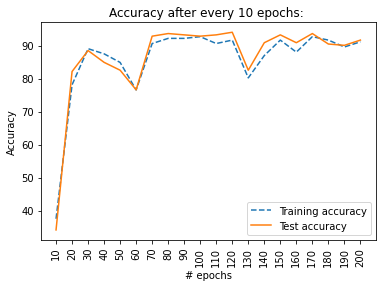

In [297]:
acc10 = [acc_arr[i] for i in range(0, 200, 10)]
acc_test10 = [acc_test_arr[i] for i in range(0, 200, 10)]
xlab = [i for i in range(20)]
lab = [i*10 for i in range(1, 21)]
plt.plot(xlab, acc10, '--', label = "Training accuracy")
plt.plot(xlab, acc_test10, '-', label = "Test accuracy")
plt.title("Accuracy after every 10 epochs: ")
plt.legend(loc="lower right")
plt.xlabel("# epochs")
plt.ylabel("Accuracy")
plt.xticks(xlab, lab, rotation = "vertical")

plt.show()

#### Displaying **Final training and test accuracy**

In [298]:
print("Final training accuracy = ", acc_arr[199], "%")
print("Final test accuracy = ", acc_test_arr[199], "%")

Final training accuracy =  90.10416666666667 %
Final test accuracy =  88.4920634920635 %


# **Part 2: Implementation using sklearn:** 

In [299]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#### For **ANN 1**

epoch:  0


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  10


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than s

epoch:  20


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  30


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  40
epoch:  50


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  60
epoch:  70


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  80


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  90
epoch:  100


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  110


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  120


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  130
epoch:  140


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  150
epoch:  160


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  170
epoch:  180


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  190


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

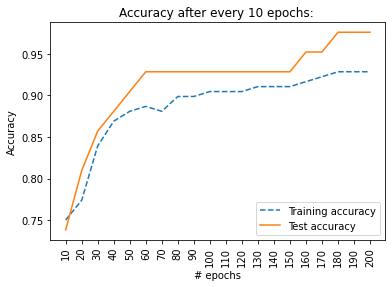

In [300]:
mlp = MLPClassifier(solver='sgd', activation='logistic', learning_rate_init=0.01, alpha=1e-6,
                    hidden_layer_sizes=(32),
                    max_iter=200,
                    batch_size=32,
                    random_state=42)

mlp.n_outputs_ = 3
mlp.out_activation_ = "softmax"

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_BATCH = 32
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < int(N_EPOCHS/10):
    print('epoch: ', epoch*10)
    # SHUFFLING
    # random_perm = np.random.permutation(X_train.shape[0])
    
    for j in range(10):
        mini_batch_index = 0
        while True:
            # MINI-BATCH
            # indices = X_train[mini_batch_index:mini_batch_index + N_BATCH]
            mlp.partial_fit(X_train[mini_batch_index:mini_batch_index + N_BATCH], y_train[mini_batch_index:mini_batch_index + N_BATCH], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))

    epoch += 1

""" Plot """
# fig, ax = plt.subplots(2, sharex=True, sharey=True)
# ax[0].plot(scores_train)
# ax[0].set_title('Train')
# ax[1].plot(scores_test)
# ax[1].set_title('Test')
# fig.suptitle("Accuracy over epochs", fontsize=14)
# plt.show()

xlab = [i for i in range(20)]
lab = [i*10 for i in range(1, 21)]
plt.plot(xlab, scores_train, '--', label = "Training accuracy")
plt.plot(xlab, scores_test, '-', label = "Test accuracy")
plt.title("Accuracy after every 10 epochs: ")
plt.legend(loc="lower right")
plt.xlabel("# epochs")
plt.ylabel("Accuracy")
plt.xticks(xlab, lab, rotation = "vertical")

plt.show()

Printing **Final Training and Test Accuracies**

In [301]:
mean_train_acc = mlp.score(X_train, y_train)
print("Final training accuracy (after 200 epochs): ", mean_train_acc*100, "%")
mean_test_acc = mlp.score(X_test, y_test)
print("Final test accuracy (after 200 epochs): ", mean_test_acc*100, "%")

Final training accuracy (after 200 epochs):  92.85714285714286 %
Final test accuracy (after 200 epochs):  97.61904761904762 %


For **ANN2**

epoch:  0
epoch:  10


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  20


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  30
epoch:  40


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  50
epoch:  60


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  70


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than s

epoch:  80
epoch:  90


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  100


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  110


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  120


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  130
epoch:  140


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  150
epoch:  160


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  170


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

epoch:  180


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

epoch:  190


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when 

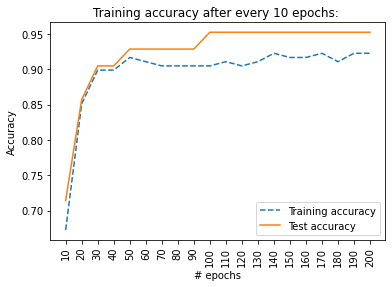

In [302]:
clf = MLPClassifier(solver='sgd', activation='relu', learning_rate_init=0.01, alpha=1e-6,
                    hidden_layer_sizes=(64, 32),
                    max_iter=200,
                    batch_size=32,
                    random_state=42)

clf.n_outputs_ = 3
clf.out_activation_ = "softmax"

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_BATCH = 32
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < int(N_EPOCHS/10):
    print('epoch: ', epoch*10)
    # SHUFFLING
    # random_perm = np.random.permutation(X_train.shape[0])
    
    for j in range(10):
        mini_batch_index = 0
        while True:
            # MINI-BATCH
            # indices = X_train[mini_batch_index:mini_batch_index + N_BATCH]
            clf.partial_fit(X_train[mini_batch_index:mini_batch_index + N_BATCH], y_train[mini_batch_index:mini_batch_index + N_BATCH], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

    # SCORE TRAIN
    scores_train.append(clf.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(clf.score(X_test, y_test))

    epoch += 1

""" Plot """
# fig, ax = plt.subplots(2, sharex=True, sharey=True)
# ax[0].plot(scores_train)
# ax[0].set_title('Train')
# ax[1].plot(scores_test)
# ax[1].set_title('Test')
# fig.suptitle("Accuracy over epochs", fontsize=14)
# plt.show()

xlab = [i for i in range(20)]
lab = [i*10 for i in range(1, 21)]
plt.plot(xlab, scores_train, '--', label = "Training accuracy")
plt.plot(xlab, scores_test, '-', label = "Test accuracy")
plt.title("Training accuracy after every 10 epochs: ")
plt.legend(loc="lower right")
plt.xlabel("# epochs")
plt.ylabel("Accuracy")
plt.xticks(xlab, lab, rotation = "vertical")

plt.show()

Printing **Final Training and Test Accuracies**

In [303]:
mean_train_acc = clf.score(X_train, y_train)
print("Final training accuracy (after 200 epochs): ", mean_train_acc*100, "%")
mean_test_acc = clf.score(X_test, y_test)
print("Final test accuracy (after 200 epochs): ", mean_test_acc*100, "%")

Final training accuracy (after 200 epochs):  92.26190476190477 %
Final test accuracy (after 200 epochs):  95.23809523809523 %
